In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/frenchenglish-translation/fra.tsv


#### Importing data

In [2]:
data = pd.read_csv('/kaggle/input/frenchenglish-translation/fra.tsv', delimiter='\t')
data.head()

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


#### Since the dataset has around 1,50,000 training examples but we will be using only 30,000 rows to keep it simple.

In [3]:
data = data.iloc[:30000, :]
train, test = train_test_split(data, test_size=0.1, random_state=42)

english = train.english.values
french = train.french.values

#### Exploring dataset

In [4]:
print("Length of english sentence ", len(english))
print("Length of french sentence ", len(french))
print('-'*20)
print(english[100])
print('-'*20)
print(french[100])

Length of english sentence  27000
Length of french sentence  27000
--------------------
We'd better get going.
--------------------
Nous ferions mieux d'y aller !


#### Remove all punctuations from text

In [5]:
english = [s.translate(str.maketrans('', '', string.punctuation)) for s in english]
french = [s.translate(str.maketrans('', '', string.punctuation)) for s in french]

print(english[100])
print('-'*20)
print(french[100])

Wed better get going
--------------------
Nous ferions mieux dy aller 


#### Convert all examples to lowercase

In [6]:
english = [s.lower() if isinstance(s, str) else s for s in english]
french = [s.lower() if isinstance(s, str) else s for s in french]

print(english[100])
print('-'*20)
print(french[100])

wed better get going
--------------------
nous ferions mieux dy aller 


#### Visualise the length of examples

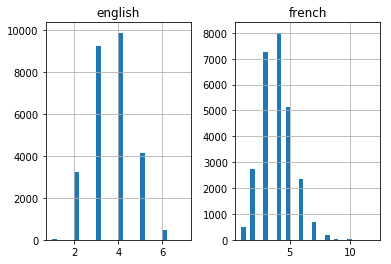

In [7]:
eng_l = [len(s.split()) for s in english]
fre_l = [len(s.split()) for s in french]

length_df = pd.DataFrame({'english': eng_l, 'french': fre_l})
length_df.hist(bins=30)
plt.show()

In [8]:
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, RepeatVector, Dropout, Bidirectional

Using TensorFlow backend.


In [9]:
def tokenizer(corpus):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    return tokenizer

english_tokenizer = tokenizer(english)
french_tokenizer = tokenizer(french)

word_index_english = english_tokenizer.word_index
word_index_french = french_tokenizer.word_index

eng_vocab_size = len(word_index_english) + 1
fre_vocab_size = len(word_index_french) + 1

In [10]:
print("Size of english vocab:", len(word_index_english))
print("Size of french vocab:", len(word_index_french))

Size of english vocab: 4500
Size of french vocab: 10061


In [11]:
max_len_eng = max(eng_l)
max_len_fre = max(fre_l)

print("Max length of english sentence:", max_len_eng)
print("Max length of french sentence:", max_len_fre)

Max length of english sentence: 7
Max length of french sentence: 12


In [12]:
def encode_sequences(tokenizer, length, text):
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=length, padding='post')
    return sequences

In [13]:
eng_seq = encode_sequences(english_tokenizer, max_len_eng, english)
fre_seq = encode_sequences(french_tokenizer, max_len_fre, french)

print(eng_seq[10])
print(fre_seq[10])

[ 19   2 298   0   0   0   0]
[163  93 122  17  39   0   0   0   0   0   0   0]


In [14]:
def nmt_model(in_vocab_size, out_vocab_size, in_timestep, out_timestep, units):
    model = Sequential()
    model.add(Embedding(in_vocab_size, units, input_length=in_timestep, mask_zero=True))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(LSTM(units, dropout=0.5, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(RepeatVector(out_timestep))
    model.add(Bidirectional(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(LSTM(units, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(out_vocab_size, activation="softmax"))
    return model

In [15]:
model = nmt_model(fre_vocab_size, eng_vocab_size, max_len_fre, max_len_eng, 256)

In [16]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 256)           2575872   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 12, 512)           1050624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 256)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 512)           

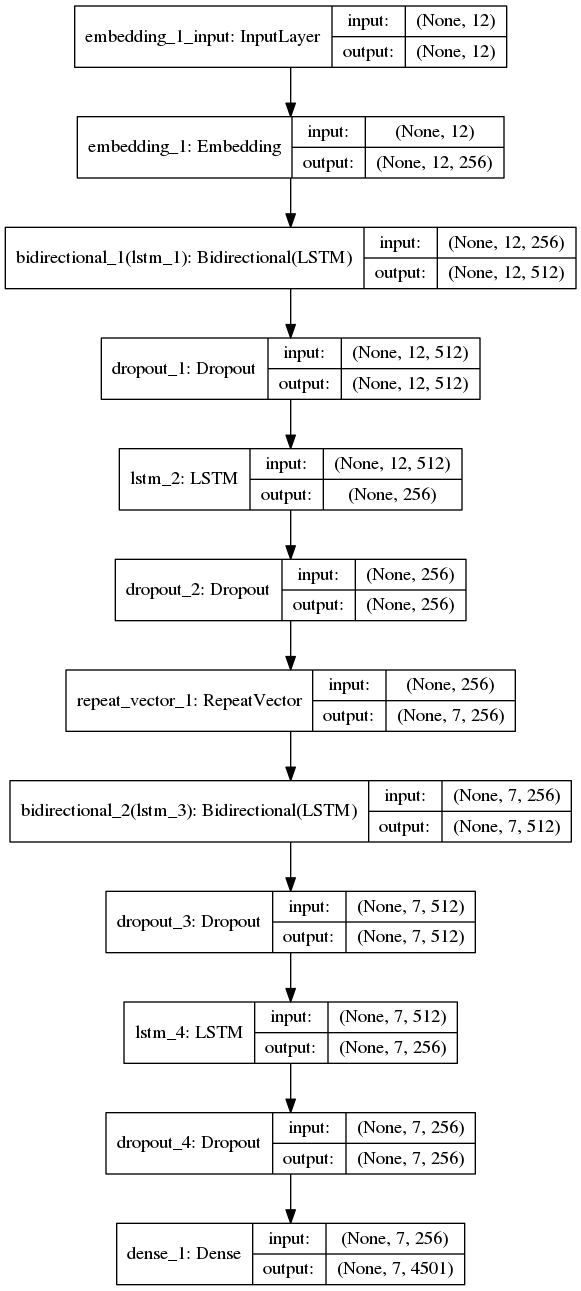

In [18]:
plot_model(model, show_shapes=True)

In [19]:
eng_seq = eng_seq.reshape(eng_seq.shape[0], eng_seq.shape[1], 1)
history = model.fit(fre_seq, eng_seq, batch_size=256, epochs=200, verbose=1, validation_split=0.1, shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 24300 samples, validate on 2700 samples
Epoch 1/200
24300/24300 [==============================] - 15s 601us/step - loss: 4.3427 - accuracy: 0.4775 - val_loss: 3.5162 - val_accuracy: 0.4852
Epoch 2/200
24300/24300 [==============================] - 10s 397us/step - loss: 3.4978 - accuracy: 0.5010 - val_loss: 3.6946 - val_accuracy: 0.4762
Epoch 3/200
24300/24300 [==============================] - 10s 393us/step - loss: 3.6557 - accuracy: 0.4878 - val_loss: 3.2571 - val_accuracy: 0.5184
Epoch 4/200
24300/24300 [==============================] - 9s 390us/step - loss: 3.2324 - accuracy: 0.5184 - val_loss: 3.1962 - val_accuracy: 0.5201
Epoch 5/200
24300/24300 [==============================] - 10s 419us/step - loss: 3.1714 - accuracy: 0.5217 - val_loss: 3.1616 - val_accuracy: 0.5219
Epoch 6/200
24300/24300 [==============================] - 10s 408us/step - loss: 3.1313 - accuracy: 0.5235 - val_loss: 3.1423 - val_accuracy: 0.5223
Epoch 7/200
24300/24300 [===========================

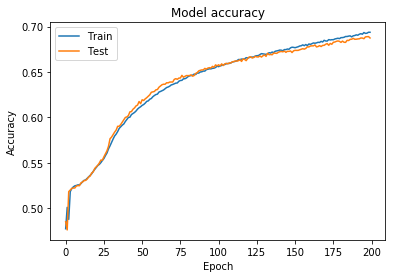

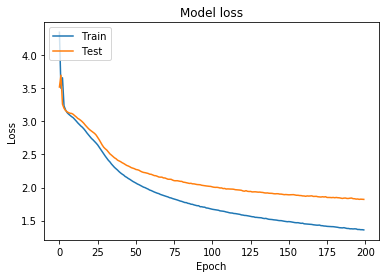

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()